In [1]:
!pip install -q segmentation-models-pytorch geojson patchify openslide-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00


In [2]:
!apt -qq update && apt -qq install -y openslide-tools

30 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Selecting previously unselected package libopenslide0.
(Reading database ... 120500 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .../openslide-tools_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking openslide-tools (3.4.1+dfsg-5build1) ...
Setting up libopenslide0 (3.4.1+dfsg-5build1) ...
Setting up openslide-tools (3.4.1+dfsg-5build1) ...
Processing triggers for man-db (2.10.2-1) ...
Proces

In [3]:
from typing import Union
import random
import os
import glob
import time
import gc

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from PIL import Image
import cv2
import geojson
from patchify import patchify

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm



OPENSLIDE_PATH  = r"C:/openslide/openslide-win64/bin"

import os
if hasattr(os, "add_dll_directory"):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
project_folder_path = "/content/drive/MyDrive/"

os.makedirs(f"{project_folder_path}models/", exist_ok=True)

In [6]:
# DATA_PATH = "/mnt/d/UCL-HDS-DissertationDataset/BRACS/BRACS_WSI"
# ANNOT_PATH = "/mnt/d/UCL-HDS-DissertationDataset/BRACS_WSI_Annotations"
PATCH_PATH = project_folder_path + "data/patches"

Fix random seeds

In [7]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Set device according to CUDA availablility

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
train_sample_patches_paths = glob.glob(PATCH_PATH + "/train_sample/*")

In [10]:
train_sample_patches_paths

['/content/drive/MyDrive/data/patches/train_sample/BRACS_1486']

/content/drive/MyDrive/data/patches/train_sample/BRACS_1486/ADH-sure-3-20x


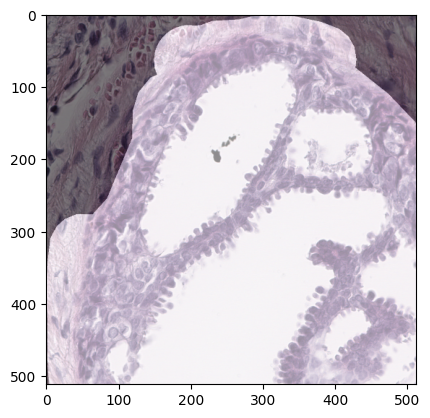

In [11]:
test_img_path = ""
test_mask_path = ""
for roi in glob.glob(train_sample_patches_paths[0] + "**/**"):
    print(roi)
    img_paths = glob.glob(roi + "/patch/*.png")
    mask_paths = glob.glob(roi + "/mask/*.png")
    test_img_path = img_paths[0]
    test_mask_path = mask_paths[0]
    img = cv2.imread(img_paths[0], cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_paths[0], cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2RGB)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.show()


    break

RGB image shape: (512, 512, 3)
RGB example pixel values: [145  89 127]
CIELAB image shape: (512, 512, 3)
CIELAB example pixel values:[115 157 116]
Black and white image shape: (512, 512)
Black and white example pixel values: 110


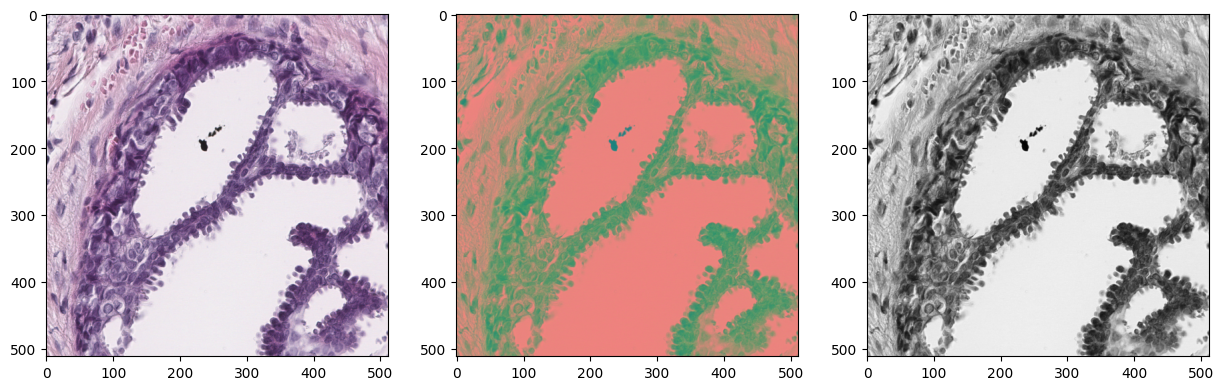

In [12]:
test_img = cv2.imread(test_img_path, cv2.IMREAD_UNCHANGED)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2RGB)
cielab_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2LAB)
bw_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1, 3, figsize=(15, 15))


print(f"RGB image shape: {test_img.shape}")
print(f"RGB example pixel values: {test_img[200, 100, :]}")

print(f"CIELAB image shape: {cielab_test_img.shape}")
print(f"CIELAB example pixel values:{cielab_test_img[200, 100, :]}")

print(f"Black and white image shape: {bw_test_img.shape}")
print(f"Black and white example pixel values: {bw_test_img[200, 100]}")

ax[0].imshow(test_img)
ax[1].imshow(cielab_test_img)
ax[2].imshow(bw_test_img, cmap="gray")
plt.show()

In [13]:
def cielab_intensify_to_rgb(img: Union[np.ndarray, torch.Tensor], rate: float):
    cie_img = np.array(img)
    if isinstance(img, torch.Tensor):
        cie_img = cie_img * 255
    cie_img[:, :, 0][cie_img[:, :, 0] > 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] > 127] * (1 + rate), 0, 255)
    cie_img[:, :, 0][cie_img[:, :, 0] < 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] < 127] * (1 - rate), 0, 255)

    cie_img[:, :, 1][cie_img[:, :, 1] > 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 1][cie_img[:, :, 1] < 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] < 127] * (1 + rate), 0, 255)

    cie_img[:, :, 2][cie_img[:, :, 2] > 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 2][cie_img[:, :, 2] < 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] < 127] * (1 + rate), 0, 255)

    cie_img = cie_img.astype(np.uint8)
    rgb_img = cv2.cvtColor(cie_img, cv2.COLOR_LAB2RGB)
    return rgb_img

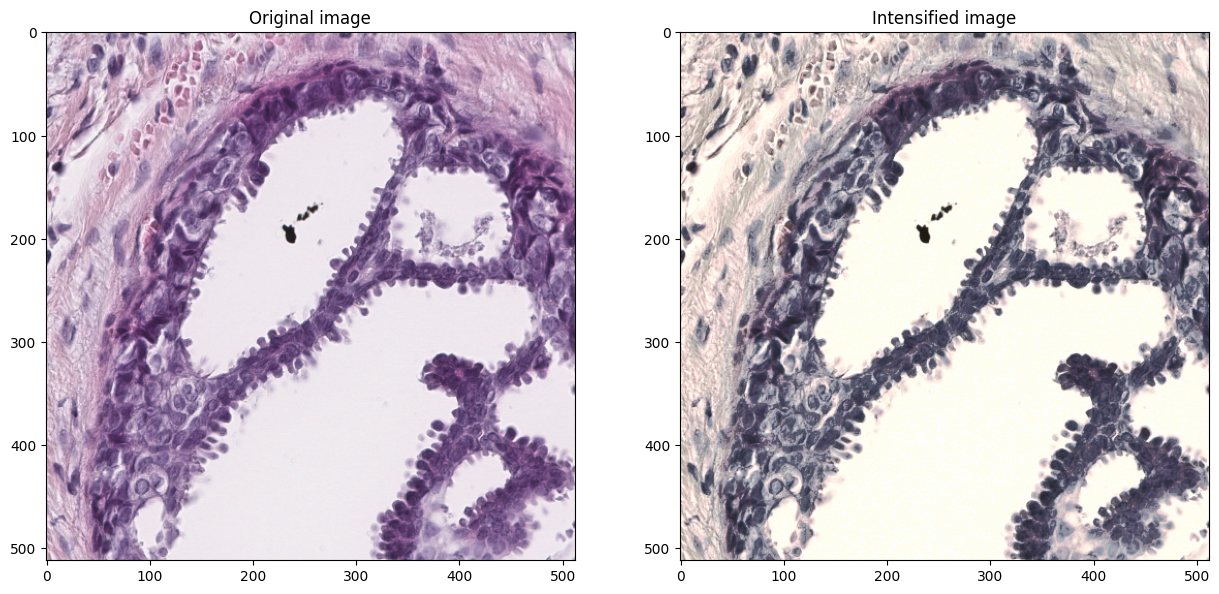

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(test_img)
ax[0].set_title("Original image")
ax[1].imshow(cielab_intensify_to_rgb(cielab_test_img, 0.1))
ax[1].set_title("Intensified image")
plt.show()

### Augmentation for training and validation

In [15]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

### Class label creation

| Class | Label |
| --- | --- |
| 0 | Type_N |
| 1 | Type_PB |
| 2 | Type_UDH |
| 3 | Type_FEA |
| 4 | Type_ADH |
| 5 | Type_DCIS |
| 6 | Type_IC |

In [16]:
train_20x_patches_paths = sorted(glob.glob(PATCH_PATH + "/train/**/*-20x"))

set(map(lambda x: "-".join(os.path.split(x)[-1].split("-")[:-2]), train_20x_patches_paths))

{'ADH',
 'ADH-sure',
 'BENIGN',
 'Benign sure',
 'Benign-sure',
 'DCIS',
 'DCIS-sure',
 'FEA',
 'FEA-sure',
 'MALIGNANT',
 'Malignant',
 'Malignant-sure',
 'Pathologica benign',
 'Pathological-benign',
 'Pathological-benign (Benign-sure)',
 'UDH',
 'UDH-sure'}

In [64]:
name_to_class_mapping = {
    "BENIGN": 1, # unable to cross reference with the roi dataset from BRACS
    "Benign sure": 1,
    "Benign-sure": 1,
    "Pathological-benign (Benign-sure)": 1, # unable to cross reference with the roi dataset from BRACS
    "Pathologica benign": 2,
    "Pathological-benign": 2,
    "UDH": 3,
    "UDH-sure": 3,
    "FEA": 4,
    "FEA-sure": 4,
    "ADH": 5,
    "ADH-sure": 5,
    "DCIS": 6,
    "DCIS-sure": 6,
    "MALIGNANT": 7,
    "Malignant": 7,
    "Malignant-sure": 7
}

class_to_type_mapping = {
    1: "Type_N",
    2: "Type_PB",
    3: "Type_UDH",
    4: "Type_FEA",
    5: "Type_ADH",
    6: "Type_DCIS",
    7: "Type_IC"
}

In [65]:
name_to_class3_mapping = {
    "BENIGN": 0, # unable to cross reference with the roi dataset from BRACS
    "Benign sure": 0,
    "Benign-sure": 0,
    "Pathological-benign (Benign-sure)": 0, # unable to cross reference with the roi dataset from BRACS
    "Pathologica benign": 1,
    "Pathological-benign": 1,
    "UDH": 1,
    "UDH-sure": 1,
    "FEA": 2,
    "FEA-sure": 2,
    "ADH": 2,
    "ADH-sure": 2,
    "DCIS": 3,
    "DCIS-sure": 3,
    "MALIGNANT": 3,
    "Malignant": 3,
    "Malignant-sure": 3
}

class3_to_type_mapping = {
    1: "Non-cancerous",
    2: "Pre-cancerous",
    3: "Cancerous"
}

### Sample Dataset and Data Loader definition

In [66]:
class PatchDataset(Dataset):
    def __init__(self, imgPaths, maskPaths, mode: str, transform=None, seed=0):
        self.imgs = imgPaths
        self.masks = maskPaths
        self.transform = transform
        self.mode = mode
        self.seed = seed

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(f"image path: {img_path}, mask path: {mask_path}")

        if self.mode == "RGB":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif self.mode == "CIELAB":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif self.mode == "BW":
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        class_id = name_to_class_mapping["-".join(img_path.split("/")[-3].split("-")[:-2])]

        # set seed so that the same transformation is applied to image and mask
        if self.transform:
            # transform the image
            random.seed(self.seed)
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed["image"].float()/255.0, transformed["mask"]/255.0
            mask[mask > 0.5] = class_id
            mask[mask <= 0.5] = 0
            mask = mask.long()
            self.seed += 1

        return img, mask

In [67]:
train_20x_img_path = []
train_20x_mask_path = []

with open(f'{project_folder_path}data/train_20x_img_paths.txt', 'r') as f:
  train_20x_img_path = f.read().splitlines()

with open(f'{project_folder_path}data/train_20x_mask_paths.txt', 'r') as f:
  train_20x_mask_path = f.read().splitlines()

train_20x_img_path.sort()
train_20x_mask_path.sort()

assert len(train_20x_img_path) == len(train_20x_mask_path), "Number of images and masks should be equal"

print("Number of 20x train images", len(train_20x_img_path))

Number of 20x train images 12056


In [68]:
val_20x_patches_paths = sorted(glob.glob(PATCH_PATH + "/val/**/*-20x"))

val_20x_img_path = []
val_20x_mask_path = []

with open(f'{project_folder_path}data/val_20x_img_paths.txt', 'r') as f:
  val_20x_img_path = f.read().splitlines()

with open(f'{project_folder_path}data/val_20x_mask_paths.txt', 'r') as f:
  val_20x_mask_path = f.read().splitlines()

val_20x_img_path.sort()
val_20x_mask_path.sort()

assert len(val_20x_img_path) == len(val_20x_mask_path), "Number of images and masks should be equal"

print("Number of 20x val images", len(val_20x_img_path))

Number of 20x val images 1072


In [69]:
train_20x_img_path = list(map(lambda x: project_folder_path + x, train_20x_img_path))
train_20x_mask_path = list(map(lambda x: project_folder_path + x, train_20x_mask_path))
val_20x_img_path = list(map(lambda x: project_folder_path + x, val_20x_img_path))
val_20x_mask_path = list(map(lambda x: project_folder_path + x, val_20x_mask_path))

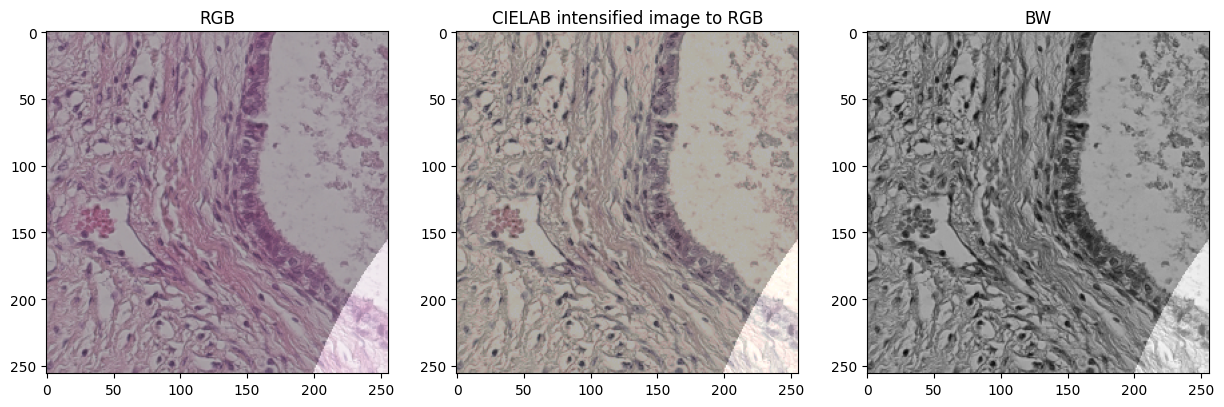

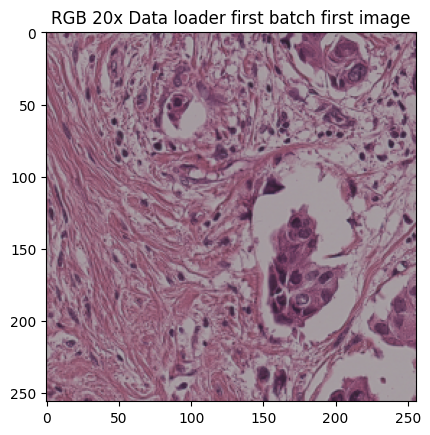

In [31]:
patch_rgb_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="RGB",
    transform=train_transform,
    seed=0
)

patch_cielab_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="CIELAB",
    transform=train_transform,
    seed=0
)

patch_bw_20x_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="BW",
    transform=train_transform,
    seed=0
)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].title.set_text("RGB")
rgb_img, rgb_mask = patch_rgb_20x_dataset[0]
ax[0].imshow(rgb_img.permute(1, 2, 0))
ax[0].imshow(rgb_mask > 0, alpha=0.3, cmap="gray")

ax[1].title.set_text("CIELAB intensified image to RGB")
cielab_img, cielab_mask = patch_cielab_20x_dataset[0]
ax[1].imshow(cielab_intensify_to_rgb(cielab_img.permute(1, 2, 0), 0.1))
ax[1].imshow(cielab_mask > 0, alpha=0.3, cmap="gray")

ax[2].title.set_text("BW")
bw_img, bw_mask = patch_bw_20x_dataset[0]
ax[2].imshow(bw_img.permute(1, 2, 0), cmap="gray")
ax[2].imshow(bw_mask > 0, alpha=0.3, cmap="gray")

plt.show()

rgb_20x_loader = DataLoader(patch_rgb_20x_dataset, batch_size=8, shuffle=True)
cielab_20x_loader = DataLoader(patch_cielab_20x_dataset, batch_size=8, shuffle=True)
bw_20x_loader = DataLoader(patch_bw_20x_dataset, batch_size=8, shuffle=True)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
img, mask = next(iter(rgb_20x_loader))

plt.title("RGB 20x Data loader first batch first image")
plt.imshow(img[0].permute(1, 2, 0))
plt.imshow(mask[0] > 0, alpha=0.3, cmap="gray")
plt.show()

### Convolution block
A double convolutional block that is used both in upsampling and downsampling blocks

In [70]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

### Downsample block
A downsampling block that wraps the convolution block and max pooling layer

In [71]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Downsample_block, self).__init__()
        self.conv_block = Conv_block(in_channels, out_channels, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=0.3)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        x = self.dropout(x)
        return x, skip

### Upsample block
A upsampling block that wraps the concatenates the skip connection features and wraps the transpose convolution layer and convolution block

In [72]:
class Upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
        super(Upsample_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=0.3)
        self.conv_block = Conv_block(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x

### UNet Model
Combine all parts for the model

In [73]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        # Downsample 64 -> 128 -> 256 -> 512
        self.down1 = Downsample_block(in_channels, features[0])
        self.down2 = Downsample_block(features[0], features[1])
        self.down3 = Downsample_block(features[1], features[2])
        self.down4 = Downsample_block(features[2], features[3])
        # Bottleneck 512 -> 1024
        self.bottleneck = Conv_block(features[3], features[3]*2, kernel_size=3, stride=1, padding="same")
        # Upsample 512 -> 256 -> 128 -> 64
        self.up1 = Upsample_block(features[3]*2, features[3])
        self.up2 = Upsample_block(features[3], features[2])
        self.up3 = Upsample_block(features[2], features[1])
        self.up4 = Upsample_block(features[1], features[0])
        self.out = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # Downsample 64 -> 128 -> 256 -> 512
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        # Bottleneck 512 -> 1024
        x = self.bottleneck(x)
        # Upsample 512 -> 256 -> 128 -> 64 with concatenation and skip connections
        x = self.up1(x, skip4)
        x = self.up2(x, skip3)
        x = self.up3(x, skip2)
        x = self.up4(x, skip1)
        x = self.out(x)
        return x

### Model compile and Training

Example for model compilation

In [74]:
model = torch.compile(UNet(out_channels=8).to(device))

Define training loop

In [75]:
def run_train_loop(
        model: UNet, num_classes:int,
        train_batches: DataLoader, valid_batches: DataLoader, train_set_len: int, val_set_len: int,
        epochs: int, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,
        set_name: str
    ):
    model.to(device)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": []
    }

    for epoch in range(epochs):
        # set the model in training phase
        model.train()

        total_train_loss = 0
        total_val_loss = 0
        train_dice = 0
        val_dice = 0

        for data, targets in tqdm(train_batches):
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            output = model(data)
            loss = criterion(output, targets)

            # backward
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            total_train_loss += loss.detach()*data.size(0)

            # evaluate dice coefficient on test set
            tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, dim=1).long(), targets, mode="multiclass", num_classes=num_classes)
            train_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

        # set the model in evaluation phase
        with torch.no_grad():
            model.eval()

            for data, targets in valid_batches:
                data = data.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                # forward
                output = model(data)
                loss = criterion(output, targets)

                total_val_loss += loss.detach()*data.size(0)

                # evaluate dice coefficient on test set
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, dim=1).long(), targets, mode="multiclass", num_classes=num_classes)
                val_dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

        # compute the average loss and accuracy
        avg_train_loss = total_train_loss.cpu() / train_set_len
        avg_val_loss = total_val_loss.cpu() / val_set_len

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)

        if (epoch+1) % 20 == 0:
            torch.save(
                {
                    "epoch": epoch+1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "history": history,
                },
                f"{set_name}_model_epoch{epoch+1}.pth"
            )

        # print the loss and accuracy for the epoch
        print(f"Epoch {(epoch+1)}/{epochs} Train Loss: {avg_train_loss:.4f} Validation Loss: {avg_val_loss:.4f}, Train Dice Score: {train_dice:.4f} Validation Dice Score: {val_dice:.4f}")

    return history

In [76]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="validation loss")
    plt.title("Loss vs epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_dice"], label="train dice score")
    plt.plot(history["val_dice"], label="validation dice score")
    plt.title("Dice score vs epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Dice Coefficient")
    plt.legend()
    plt.show()

Create seed worker for data loader

In [77]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)

<i>Optional garbage collection to free up space</i>

In [78]:
torch.cuda.empty_cache()
gc.collect()

2040

#### Sample training
RGB 20x, learning rate: 1e-4, batch size: 32, 100 epochs

100%|██████████| 377/377 [20:41<00:00,  3.29s/it]


Epoch 1/100 Train Loss: 0.7611 Validation Loss: 0.3517, Train Dice Score: 0.2021 Validation Dice Score: 0.1115


100%|██████████| 377/377 [01:33<00:00,  4.05it/s]


Epoch 2/100 Train Loss: 0.7235 Validation Loss: 0.3503, Train Dice Score: 0.1962 Validation Dice Score: 0.0578


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 3/100 Train Loss: 0.7067 Validation Loss: 0.3405, Train Dice Score: 0.2506 Validation Dice Score: 0.1166


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 4/100 Train Loss: 0.6778 Validation Loss: 0.3383, Train Dice Score: 0.2794 Validation Dice Score: 0.1273


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 5/100 Train Loss: 0.6764 Validation Loss: 0.3406, Train Dice Score: 0.3520 Validation Dice Score: 0.1208


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 6/100 Train Loss: 0.6645 Validation Loss: 0.3396, Train Dice Score: 0.3318 Validation Dice Score: 0.1168


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 7/100 Train Loss: 0.6503 Validation Loss: 0.3397, Train Dice Score: 0.2035 Validation Dice Score: 0.0910


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 8/100 Train Loss: 0.6462 Validation Loss: 0.3364, Train Dice Score: 0.4085 Validation Dice Score: 0.1051


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 9/100 Train Loss: 0.6409 Validation Loss: 0.3384, Train Dice Score: 0.2570 Validation Dice Score: 0.1510


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 10/100 Train Loss: 0.6281 Validation Loss: 0.3334, Train Dice Score: 0.3512 Validation Dice Score: 0.1276


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 11/100 Train Loss: 0.6323 Validation Loss: 0.3346, Train Dice Score: 0.2452 Validation Dice Score: 0.0786


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 12/100 Train Loss: 0.6232 Validation Loss: 0.3302, Train Dice Score: 0.2026 Validation Dice Score: 0.1335


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 13/100 Train Loss: 0.6100 Validation Loss: 0.3347, Train Dice Score: 0.2787 Validation Dice Score: 0.1016


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 14/100 Train Loss: 0.6067 Validation Loss: 0.3277, Train Dice Score: 0.3493 Validation Dice Score: 0.1429


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 15/100 Train Loss: 0.6006 Validation Loss: 0.3258, Train Dice Score: 0.2572 Validation Dice Score: 0.1195


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 16/100 Train Loss: 0.5921 Validation Loss: 0.3297, Train Dice Score: 0.2799 Validation Dice Score: 0.1022


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 17/100 Train Loss: 0.5865 Validation Loss: 0.3241, Train Dice Score: 0.3244 Validation Dice Score: 0.1257


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 18/100 Train Loss: 0.5873 Validation Loss: 0.3215, Train Dice Score: 0.2879 Validation Dice Score: 0.1192


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 19/100 Train Loss: 0.5817 Validation Loss: 0.3204, Train Dice Score: 0.3123 Validation Dice Score: 0.1023


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 20/100 Train Loss: 0.5710 Validation Loss: 0.3189, Train Dice Score: 0.1949 Validation Dice Score: 0.1268


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 21/100 Train Loss: 0.5742 Validation Loss: 0.3085, Train Dice Score: 0.2226 Validation Dice Score: 0.1240


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 22/100 Train Loss: 0.5722 Validation Loss: 0.3232, Train Dice Score: 0.2932 Validation Dice Score: 0.0918


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 23/100 Train Loss: 0.5599 Validation Loss: 0.3166, Train Dice Score: 0.5078 Validation Dice Score: 0.0937


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 24/100 Train Loss: 0.5669 Validation Loss: 0.3188, Train Dice Score: 0.3626 Validation Dice Score: 0.1554


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 25/100 Train Loss: 0.5522 Validation Loss: 0.3211, Train Dice Score: 0.2816 Validation Dice Score: 0.1324


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 26/100 Train Loss: 0.5562 Validation Loss: 0.3142, Train Dice Score: 0.3163 Validation Dice Score: 0.1018


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 27/100 Train Loss: 0.5484 Validation Loss: 0.3051, Train Dice Score: 0.5351 Validation Dice Score: 0.1103


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 28/100 Train Loss: 0.5459 Validation Loss: 0.3085, Train Dice Score: 0.4304 Validation Dice Score: 0.1105


100%|██████████| 377/377 [01:28<00:00,  4.28it/s]


Epoch 29/100 Train Loss: 0.5450 Validation Loss: 0.3059, Train Dice Score: 0.3692 Validation Dice Score: 0.1313


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 30/100 Train Loss: 0.5420 Validation Loss: 0.3037, Train Dice Score: 0.1848 Validation Dice Score: 0.1379


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 31/100 Train Loss: 0.5393 Validation Loss: 0.3077, Train Dice Score: 0.4366 Validation Dice Score: 0.1150


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 32/100 Train Loss: 0.5391 Validation Loss: 0.3153, Train Dice Score: 0.5487 Validation Dice Score: 0.1148


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 33/100 Train Loss: 0.5302 Validation Loss: 0.3099, Train Dice Score: 0.3801 Validation Dice Score: 0.1197


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 34/100 Train Loss: 0.5296 Validation Loss: 0.3115, Train Dice Score: 0.3821 Validation Dice Score: 0.1473


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 35/100 Train Loss: 0.5296 Validation Loss: 0.3083, Train Dice Score: 0.3437 Validation Dice Score: 0.1478


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 36/100 Train Loss: 0.5260 Validation Loss: 0.3146, Train Dice Score: 0.3021 Validation Dice Score: 0.1017


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 37/100 Train Loss: 0.5240 Validation Loss: 0.3027, Train Dice Score: 0.4747 Validation Dice Score: 0.1216


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 38/100 Train Loss: 0.5235 Validation Loss: 0.3042, Train Dice Score: 0.2594 Validation Dice Score: 0.1128


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 39/100 Train Loss: 0.5199 Validation Loss: 0.2982, Train Dice Score: 0.3805 Validation Dice Score: 0.1562


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 40/100 Train Loss: 0.5275 Validation Loss: 0.3061, Train Dice Score: 0.3681 Validation Dice Score: 0.1152


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 41/100 Train Loss: 0.5159 Validation Loss: 0.2980, Train Dice Score: 0.3958 Validation Dice Score: 0.1107


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 42/100 Train Loss: 0.5146 Validation Loss: 0.3029, Train Dice Score: 0.3535 Validation Dice Score: 0.1267


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 43/100 Train Loss: 0.5167 Validation Loss: 0.3119, Train Dice Score: 0.4387 Validation Dice Score: 0.1391


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 44/100 Train Loss: 0.5098 Validation Loss: 0.3016, Train Dice Score: 0.3938 Validation Dice Score: 0.1333


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 45/100 Train Loss: 0.5147 Validation Loss: 0.2979, Train Dice Score: 0.5501 Validation Dice Score: 0.1151


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 46/100 Train Loss: 0.5021 Validation Loss: 0.2978, Train Dice Score: 0.3437 Validation Dice Score: 0.1426


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 47/100 Train Loss: 0.5074 Validation Loss: 0.3005, Train Dice Score: 0.2521 Validation Dice Score: 0.1382


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 48/100 Train Loss: 0.5111 Validation Loss: 0.3008, Train Dice Score: 0.4347 Validation Dice Score: 0.1975


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 49/100 Train Loss: 0.5075 Validation Loss: 0.2941, Train Dice Score: 0.4655 Validation Dice Score: 0.1497


100%|██████████| 377/377 [01:28<00:00,  4.28it/s]


Epoch 50/100 Train Loss: 0.5051 Validation Loss: 0.2912, Train Dice Score: 0.4880 Validation Dice Score: 0.1626


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 51/100 Train Loss: 0.5039 Validation Loss: 0.3019, Train Dice Score: 0.4442 Validation Dice Score: 0.1360


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 52/100 Train Loss: 0.4975 Validation Loss: 0.3045, Train Dice Score: 0.6269 Validation Dice Score: 0.1396


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 53/100 Train Loss: 0.4944 Validation Loss: 0.2934, Train Dice Score: 0.4211 Validation Dice Score: 0.1494


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 54/100 Train Loss: 0.5015 Validation Loss: 0.2968, Train Dice Score: 0.2981 Validation Dice Score: 0.1793


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 55/100 Train Loss: 0.4939 Validation Loss: 0.2907, Train Dice Score: 0.4599 Validation Dice Score: 0.1405


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 56/100 Train Loss: 0.4920 Validation Loss: 0.3004, Train Dice Score: 0.3432 Validation Dice Score: 0.1280


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 57/100 Train Loss: 0.4890 Validation Loss: 0.2956, Train Dice Score: 0.2640 Validation Dice Score: 0.1339


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 58/100 Train Loss: 0.4837 Validation Loss: 0.3035, Train Dice Score: 0.2726 Validation Dice Score: 0.1378


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 59/100 Train Loss: 0.4887 Validation Loss: 0.2917, Train Dice Score: 0.4805 Validation Dice Score: 0.1603


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 60/100 Train Loss: 0.4902 Validation Loss: 0.2902, Train Dice Score: 0.3593 Validation Dice Score: 0.1951


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 61/100 Train Loss: 0.4877 Validation Loss: 0.2943, Train Dice Score: 0.4653 Validation Dice Score: 0.1784


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 62/100 Train Loss: 0.4820 Validation Loss: 0.2912, Train Dice Score: 0.5533 Validation Dice Score: 0.2001


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 63/100 Train Loss: 0.4824 Validation Loss: 0.2920, Train Dice Score: 0.3908 Validation Dice Score: 0.1374


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 64/100 Train Loss: 0.4855 Validation Loss: 0.2901, Train Dice Score: 0.4719 Validation Dice Score: 0.2115


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 65/100 Train Loss: 0.4781 Validation Loss: 0.2910, Train Dice Score: 0.4979 Validation Dice Score: 0.1327


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 66/100 Train Loss: 0.4797 Validation Loss: 0.2966, Train Dice Score: 0.4400 Validation Dice Score: 0.1664


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 67/100 Train Loss: 0.4766 Validation Loss: 0.2938, Train Dice Score: 0.4551 Validation Dice Score: 0.1530


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 68/100 Train Loss: 0.4769 Validation Loss: 0.2844, Train Dice Score: 0.3124 Validation Dice Score: 0.1980


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 69/100 Train Loss: 0.4772 Validation Loss: 0.2983, Train Dice Score: 0.5045 Validation Dice Score: 0.1863


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 70/100 Train Loss: 0.4739 Validation Loss: 0.2877, Train Dice Score: 0.4749 Validation Dice Score: 0.1622


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 71/100 Train Loss: 0.4697 Validation Loss: 0.2808, Train Dice Score: 0.3631 Validation Dice Score: 0.1571


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 72/100 Train Loss: 0.4720 Validation Loss: 0.2811, Train Dice Score: 0.5103 Validation Dice Score: 0.1937


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 73/100 Train Loss: 0.4731 Validation Loss: 0.2945, Train Dice Score: 0.3047 Validation Dice Score: 0.1934


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 74/100 Train Loss: 0.4629 Validation Loss: 0.2872, Train Dice Score: 0.6163 Validation Dice Score: 0.1934


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 75/100 Train Loss: 0.4630 Validation Loss: 0.2951, Train Dice Score: 0.4530 Validation Dice Score: 0.1698


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 76/100 Train Loss: 0.4715 Validation Loss: 0.2878, Train Dice Score: 0.4305 Validation Dice Score: 0.1683


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 77/100 Train Loss: 0.4673 Validation Loss: 0.3000, Train Dice Score: 0.2893 Validation Dice Score: 0.2035


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 78/100 Train Loss: 0.4572 Validation Loss: 0.2850, Train Dice Score: 0.5340 Validation Dice Score: 0.1744


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 79/100 Train Loss: 0.4576 Validation Loss: 0.2913, Train Dice Score: 0.5572 Validation Dice Score: 0.1673


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 80/100 Train Loss: 0.4539 Validation Loss: 0.2862, Train Dice Score: 0.3559 Validation Dice Score: 0.1797


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 81/100 Train Loss: 0.4605 Validation Loss: 0.2893, Train Dice Score: 0.4254 Validation Dice Score: 0.1736


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 82/100 Train Loss: 0.4565 Validation Loss: 0.2907, Train Dice Score: 0.4671 Validation Dice Score: 0.1473


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 83/100 Train Loss: 0.4607 Validation Loss: 0.2911, Train Dice Score: 0.5529 Validation Dice Score: 0.1896


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 84/100 Train Loss: 0.4505 Validation Loss: 0.2907, Train Dice Score: 0.4615 Validation Dice Score: 0.1685


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 85/100 Train Loss: 0.4563 Validation Loss: 0.2857, Train Dice Score: 0.4477 Validation Dice Score: 0.2039


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 86/100 Train Loss: 0.4491 Validation Loss: 0.2887, Train Dice Score: 0.4546 Validation Dice Score: 0.1785


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 87/100 Train Loss: 0.4531 Validation Loss: 0.2880, Train Dice Score: 0.6203 Validation Dice Score: 0.1882


100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


Epoch 88/100 Train Loss: 0.4495 Validation Loss: 0.2888, Train Dice Score: 0.3767 Validation Dice Score: 0.1766


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 89/100 Train Loss: 0.4444 Validation Loss: 0.2907, Train Dice Score: 0.4831 Validation Dice Score: 0.1899


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 90/100 Train Loss: 0.4470 Validation Loss: 0.2910, Train Dice Score: 0.3700 Validation Dice Score: 0.1900


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 91/100 Train Loss: 0.4403 Validation Loss: 0.2871, Train Dice Score: 0.4053 Validation Dice Score: 0.1485


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 92/100 Train Loss: 0.4517 Validation Loss: 0.2871, Train Dice Score: 0.5200 Validation Dice Score: 0.1883


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 93/100 Train Loss: 0.4420 Validation Loss: 0.2902, Train Dice Score: 0.4985 Validation Dice Score: 0.1781


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 94/100 Train Loss: 0.4473 Validation Loss: 0.2848, Train Dice Score: 0.4401 Validation Dice Score: 0.1903


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 95/100 Train Loss: 0.4452 Validation Loss: 0.2903, Train Dice Score: 0.5533 Validation Dice Score: 0.2366


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 96/100 Train Loss: 0.4409 Validation Loss: 0.2878, Train Dice Score: 0.6268 Validation Dice Score: 0.1903


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 97/100 Train Loss: 0.4387 Validation Loss: 0.2886, Train Dice Score: 0.5319 Validation Dice Score: 0.1901


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 98/100 Train Loss: 0.4440 Validation Loss: 0.2917, Train Dice Score: 0.3950 Validation Dice Score: 0.2029


100%|██████████| 377/377 [01:28<00:00,  4.27it/s]


Epoch 99/100 Train Loss: 0.4334 Validation Loss: 0.2903, Train Dice Score: 0.3977 Validation Dice Score: 0.1704


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]


Epoch 100/100 Train Loss: 0.4293 Validation Loss: 0.2857, Train Dice Score: 0.3290 Validation Dice Score: 0.1957
Total time taken to train the model: 10749.97s


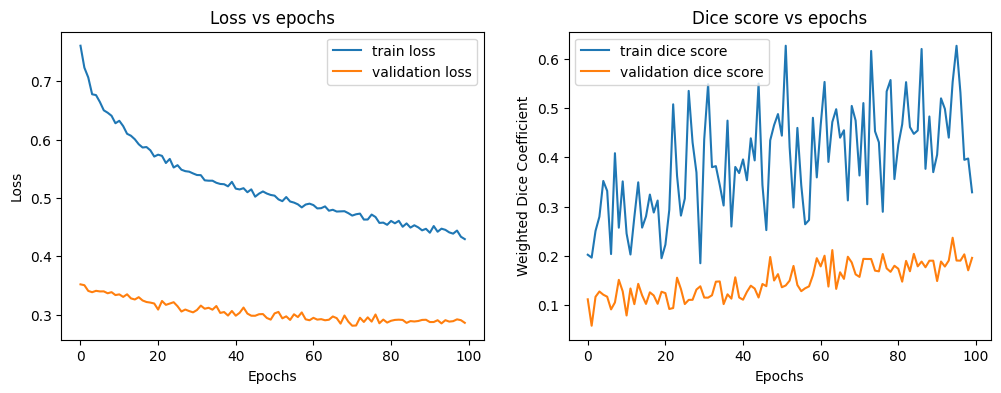

In [61]:
# recompile model
model = UNet(out_channels=8)

# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 32
EPOCHS = 100
NUM_WORKERS = 12

patch_rgb_20x_train_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="RGB",
    transform=train_transform,
    seed=0
)

patch_rgb_20x_val_dataset = PatchDataset(
    imgPaths=val_20x_img_path,
    maskPaths=val_20x_mask_path,
    mode="RGB",
    transform=val_transform,
    seed=0
)

if __name__ == "__main__":

    worker_g = torch.Generator()
    worker_g.manual_seed(0)
    train_batches = DataLoader(
        patch_rgb_20x_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_rgb_20x_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )

    # define the loss function and the optimizer
    criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    # train the network
    history = run_train_loop(model, 8, train_batches, valid_batches, len(patch_rgb_20x_train_dataset), len(patch_rgb_20x_val_dataset), EPOCHS, criterion, optimizer, "unetset1")
    torch.save(
        {
            "epoch": 100,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
        },
        f"unetset1_model_final.pth"
    )

    # display the total time needed to perform the training
    end_time = time.time()
    print(f"Total time taken to train the model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history)

<i>Optional garbage collection to free up space</i>

In [62]:
torch.cuda.empty_cache()
gc.collect()

7041

#### Sample training
CIELAB 20x, learning rate: 1e-4, batch size: 32, 100 epochs

100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 1/100 Train Loss: 0.7644 Validation Loss: 0.3487, Train Dice Score: 0.2224 Validation Dice Score: 0.0987


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 2/100 Train Loss: 0.7257 Validation Loss: 0.3456, Train Dice Score: 0.2770 Validation Dice Score: 0.1076


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 3/100 Train Loss: 0.6929 Validation Loss: 0.3410, Train Dice Score: 0.2961 Validation Dice Score: 0.1414


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 4/100 Train Loss: 0.6798 Validation Loss: 0.3364, Train Dice Score: 0.2487 Validation Dice Score: 0.1300


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 5/100 Train Loss: 0.6568 Validation Loss: 0.3430, Train Dice Score: 0.2015 Validation Dice Score: 0.1022


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 6/100 Train Loss: 0.6438 Validation Loss: 0.3309, Train Dice Score: 0.3561 Validation Dice Score: 0.1580


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 7/100 Train Loss: 0.6339 Validation Loss: 0.3388, Train Dice Score: 0.3516 Validation Dice Score: 0.0967


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 8/100 Train Loss: 0.6352 Validation Loss: 0.3347, Train Dice Score: 0.3348 Validation Dice Score: 0.1055


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 9/100 Train Loss: 0.6227 Validation Loss: 0.3275, Train Dice Score: 0.2922 Validation Dice Score: 0.1237


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 10/100 Train Loss: 0.6133 Validation Loss: 0.3347, Train Dice Score: 0.2650 Validation Dice Score: 0.1232


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 11/100 Train Loss: 0.6109 Validation Loss: 0.3316, Train Dice Score: 0.3054 Validation Dice Score: 0.1192


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 12/100 Train Loss: 0.6061 Validation Loss: 0.3272, Train Dice Score: 0.3279 Validation Dice Score: 0.1278


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 13/100 Train Loss: 0.5994 Validation Loss: 0.3265, Train Dice Score: 0.2923 Validation Dice Score: 0.1439


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 14/100 Train Loss: 0.5886 Validation Loss: 0.3339, Train Dice Score: 0.3325 Validation Dice Score: 0.0925


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 15/100 Train Loss: 0.5882 Validation Loss: 0.3188, Train Dice Score: 0.3211 Validation Dice Score: 0.1619


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 16/100 Train Loss: 0.5846 Validation Loss: 0.3206, Train Dice Score: 0.2784 Validation Dice Score: 0.1055


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 17/100 Train Loss: 0.5736 Validation Loss: 0.3181, Train Dice Score: 0.2798 Validation Dice Score: 0.1278


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 18/100 Train Loss: 0.5732 Validation Loss: 0.3245, Train Dice Score: 0.3059 Validation Dice Score: 0.0997


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 19/100 Train Loss: 0.5579 Validation Loss: 0.3261, Train Dice Score: 0.3159 Validation Dice Score: 0.1315


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 20/100 Train Loss: 0.5720 Validation Loss: 0.3213, Train Dice Score: 0.4155 Validation Dice Score: 0.1567


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 21/100 Train Loss: 0.5578 Validation Loss: 0.3177, Train Dice Score: 0.3211 Validation Dice Score: 0.0843


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 22/100 Train Loss: 0.5587 Validation Loss: 0.3120, Train Dice Score: 0.3340 Validation Dice Score: 0.0902


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 23/100 Train Loss: 0.5526 Validation Loss: 0.3089, Train Dice Score: 0.3948 Validation Dice Score: 0.0981


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 24/100 Train Loss: 0.5473 Validation Loss: 0.3132, Train Dice Score: 0.4149 Validation Dice Score: 0.1518


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 25/100 Train Loss: 0.5585 Validation Loss: 0.3094, Train Dice Score: 0.4245 Validation Dice Score: 0.1403


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 26/100 Train Loss: 0.5382 Validation Loss: 0.3116, Train Dice Score: 0.5182 Validation Dice Score: 0.1339


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 27/100 Train Loss: 0.5410 Validation Loss: 0.3076, Train Dice Score: 0.3396 Validation Dice Score: 0.1456


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 28/100 Train Loss: 0.5387 Validation Loss: 0.3164, Train Dice Score: 0.2386 Validation Dice Score: 0.1327


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 29/100 Train Loss: 0.5345 Validation Loss: 0.3032, Train Dice Score: 0.3810 Validation Dice Score: 0.1198


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 30/100 Train Loss: 0.5385 Validation Loss: 0.3027, Train Dice Score: 0.4543 Validation Dice Score: 0.1139


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 31/100 Train Loss: 0.5312 Validation Loss: 0.3039, Train Dice Score: 0.3081 Validation Dice Score: 0.1085


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 32/100 Train Loss: 0.5292 Validation Loss: 0.3068, Train Dice Score: 0.3402 Validation Dice Score: 0.2245


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 33/100 Train Loss: 0.5287 Validation Loss: 0.3049, Train Dice Score: 0.4711 Validation Dice Score: 0.1369


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 34/100 Train Loss: 0.5239 Validation Loss: 0.3054, Train Dice Score: 0.4125 Validation Dice Score: 0.1197


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 35/100 Train Loss: 0.5227 Validation Loss: 0.3014, Train Dice Score: 0.3579 Validation Dice Score: 0.1316


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 36/100 Train Loss: 0.5218 Validation Loss: 0.3037, Train Dice Score: 0.3672 Validation Dice Score: 0.1655


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 37/100 Train Loss: 0.5192 Validation Loss: 0.3010, Train Dice Score: 0.2876 Validation Dice Score: 0.1244


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 38/100 Train Loss: 0.5182 Validation Loss: 0.2940, Train Dice Score: 0.2124 Validation Dice Score: 0.1248


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 39/100 Train Loss: 0.5120 Validation Loss: 0.2955, Train Dice Score: 0.4323 Validation Dice Score: 0.1597


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 40/100 Train Loss: 0.5147 Validation Loss: 0.2958, Train Dice Score: 0.3341 Validation Dice Score: 0.1537


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 41/100 Train Loss: 0.5079 Validation Loss: 0.2957, Train Dice Score: 0.4672 Validation Dice Score: 0.1285


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 42/100 Train Loss: 0.5038 Validation Loss: 0.2927, Train Dice Score: 0.2703 Validation Dice Score: 0.1643


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 43/100 Train Loss: 0.5046 Validation Loss: 0.2964, Train Dice Score: 0.3428 Validation Dice Score: 0.1479


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 44/100 Train Loss: 0.5035 Validation Loss: 0.2989, Train Dice Score: 0.3979 Validation Dice Score: 0.1231


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 45/100 Train Loss: 0.5042 Validation Loss: 0.2931, Train Dice Score: 0.3407 Validation Dice Score: 0.1486


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 46/100 Train Loss: 0.5029 Validation Loss: 0.2910, Train Dice Score: 0.4031 Validation Dice Score: 0.1352


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 47/100 Train Loss: 0.5033 Validation Loss: 0.2926, Train Dice Score: 0.3953 Validation Dice Score: 0.1681


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 48/100 Train Loss: 0.4911 Validation Loss: 0.2979, Train Dice Score: 0.4522 Validation Dice Score: 0.1572


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 49/100 Train Loss: 0.4906 Validation Loss: 0.2905, Train Dice Score: 0.4066 Validation Dice Score: 0.2062


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 50/100 Train Loss: 0.4918 Validation Loss: 0.2952, Train Dice Score: 0.4525 Validation Dice Score: 0.1095


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 51/100 Train Loss: 0.4934 Validation Loss: 0.2935, Train Dice Score: 0.4401 Validation Dice Score: 0.2022


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 52/100 Train Loss: 0.4892 Validation Loss: 0.2951, Train Dice Score: 0.4150 Validation Dice Score: 0.1687


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 53/100 Train Loss: 0.4874 Validation Loss: 0.2862, Train Dice Score: 0.4023 Validation Dice Score: 0.1881


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 54/100 Train Loss: 0.4862 Validation Loss: 0.2896, Train Dice Score: 0.4438 Validation Dice Score: 0.1970


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 55/100 Train Loss: 0.4779 Validation Loss: 0.2955, Train Dice Score: 0.5607 Validation Dice Score: 0.1373


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 56/100 Train Loss: 0.4787 Validation Loss: 0.2935, Train Dice Score: 0.3643 Validation Dice Score: 0.1760


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 57/100 Train Loss: 0.4786 Validation Loss: 0.2919, Train Dice Score: 0.3312 Validation Dice Score: 0.1939


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 58/100 Train Loss: 0.4774 Validation Loss: 0.2887, Train Dice Score: 0.3683 Validation Dice Score: 0.1825


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 59/100 Train Loss: 0.4833 Validation Loss: 0.2874, Train Dice Score: 0.4583 Validation Dice Score: 0.1766


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 60/100 Train Loss: 0.4751 Validation Loss: 0.2980, Train Dice Score: 0.4735 Validation Dice Score: 0.1678


100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


Epoch 61/100 Train Loss: 0.4709 Validation Loss: 0.2897, Train Dice Score: 0.4625 Validation Dice Score: 0.1392


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 62/100 Train Loss: 0.4718 Validation Loss: 0.2941, Train Dice Score: 0.3501 Validation Dice Score: 0.2070


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 63/100 Train Loss: 0.4692 Validation Loss: 0.2939, Train Dice Score: 0.4185 Validation Dice Score: 0.1795


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 64/100 Train Loss: 0.4683 Validation Loss: 0.2844, Train Dice Score: 0.5536 Validation Dice Score: 0.1872


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 65/100 Train Loss: 0.4624 Validation Loss: 0.2904, Train Dice Score: 0.4522 Validation Dice Score: 0.1866


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 66/100 Train Loss: 0.4616 Validation Loss: 0.2909, Train Dice Score: 0.4731 Validation Dice Score: 0.1891


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 67/100 Train Loss: 0.4635 Validation Loss: 0.2864, Train Dice Score: 0.4304 Validation Dice Score: 0.2159


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 68/100 Train Loss: 0.4644 Validation Loss: 0.2819, Train Dice Score: 0.4552 Validation Dice Score: 0.1754


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 69/100 Train Loss: 0.4602 Validation Loss: 0.2856, Train Dice Score: 0.5123 Validation Dice Score: 0.1846


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 70/100 Train Loss: 0.4638 Validation Loss: 0.2974, Train Dice Score: 0.4645 Validation Dice Score: 0.1659


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 71/100 Train Loss: 0.4574 Validation Loss: 0.2836, Train Dice Score: 0.5146 Validation Dice Score: 0.1761


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 72/100 Train Loss: 0.4566 Validation Loss: 0.2816, Train Dice Score: 0.4786 Validation Dice Score: 0.1815


100%|██████████| 377/377 [01:28<00:00,  4.28it/s]


Epoch 73/100 Train Loss: 0.4540 Validation Loss: 0.2848, Train Dice Score: 0.4459 Validation Dice Score: 0.1846


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 74/100 Train Loss: 0.4454 Validation Loss: 0.2888, Train Dice Score: 0.5444 Validation Dice Score: 0.1769


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 75/100 Train Loss: 0.4517 Validation Loss: 0.2905, Train Dice Score: 0.5350 Validation Dice Score: 0.1763


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 76/100 Train Loss: 0.4506 Validation Loss: 0.2862, Train Dice Score: 0.4363 Validation Dice Score: 0.1960


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 77/100 Train Loss: 0.4523 Validation Loss: 0.2811, Train Dice Score: 0.3059 Validation Dice Score: 0.1794


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 78/100 Train Loss: 0.4465 Validation Loss: 0.2873, Train Dice Score: 0.4032 Validation Dice Score: 0.1590


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 79/100 Train Loss: 0.4509 Validation Loss: 0.2901, Train Dice Score: 0.4661 Validation Dice Score: 0.2266


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 80/100 Train Loss: 0.4442 Validation Loss: 0.2940, Train Dice Score: 0.4709 Validation Dice Score: 0.2062


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 81/100 Train Loss: 0.4440 Validation Loss: 0.2831, Train Dice Score: 0.4826 Validation Dice Score: 0.1707


100%|██████████| 377/377 [01:27<00:00,  4.28it/s]


Epoch 82/100 Train Loss: 0.4499 Validation Loss: 0.2901, Train Dice Score: 0.3562 Validation Dice Score: 0.1855


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 83/100 Train Loss: 0.4366 Validation Loss: 0.2812, Train Dice Score: 0.4501 Validation Dice Score: 0.2094


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 84/100 Train Loss: 0.4467 Validation Loss: 0.2831, Train Dice Score: 0.4977 Validation Dice Score: 0.1872


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 85/100 Train Loss: 0.4404 Validation Loss: 0.2840, Train Dice Score: 0.5144 Validation Dice Score: 0.1710


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 86/100 Train Loss: 0.4440 Validation Loss: 0.2869, Train Dice Score: 0.3897 Validation Dice Score: 0.1723


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 87/100 Train Loss: 0.4410 Validation Loss: 0.2880, Train Dice Score: 0.4035 Validation Dice Score: 0.1886


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 88/100 Train Loss: 0.4384 Validation Loss: 0.2879, Train Dice Score: 0.4016 Validation Dice Score: 0.2222


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 89/100 Train Loss: 0.4309 Validation Loss: 0.2879, Train Dice Score: 0.5062 Validation Dice Score: 0.1816


100%|██████████| 377/377 [01:28<00:00,  4.28it/s]


Epoch 90/100 Train Loss: 0.4315 Validation Loss: 0.2794, Train Dice Score: 0.5997 Validation Dice Score: 0.1892


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 91/100 Train Loss: 0.4303 Validation Loss: 0.2875, Train Dice Score: 0.5692 Validation Dice Score: 0.1768


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 92/100 Train Loss: 0.4346 Validation Loss: 0.2859, Train Dice Score: 0.4381 Validation Dice Score: 0.2303


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 93/100 Train Loss: 0.4307 Validation Loss: 0.2835, Train Dice Score: 0.6019 Validation Dice Score: 0.1974


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 94/100 Train Loss: 0.4333 Validation Loss: 0.2824, Train Dice Score: 0.4538 Validation Dice Score: 0.1822


100%|██████████| 377/377 [01:27<00:00,  4.30it/s]


Epoch 95/100 Train Loss: 0.4337 Validation Loss: 0.2837, Train Dice Score: 0.4522 Validation Dice Score: 0.2175


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 96/100 Train Loss: 0.4309 Validation Loss: 0.2777, Train Dice Score: 0.4581 Validation Dice Score: 0.2206


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 97/100 Train Loss: 0.4265 Validation Loss: 0.2779, Train Dice Score: 0.4381 Validation Dice Score: 0.1964


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 98/100 Train Loss: 0.4284 Validation Loss: 0.2899, Train Dice Score: 0.3642 Validation Dice Score: 0.2052


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 99/100 Train Loss: 0.4291 Validation Loss: 0.2802, Train Dice Score: 0.4831 Validation Dice Score: 0.1833


100%|██████████| 377/377 [01:27<00:00,  4.29it/s]


Epoch 100/100 Train Loss: 0.4211 Validation Loss: 0.2762, Train Dice Score: 0.4970 Validation Dice Score: 0.2097
Total time taken to train the model: 9255.74s


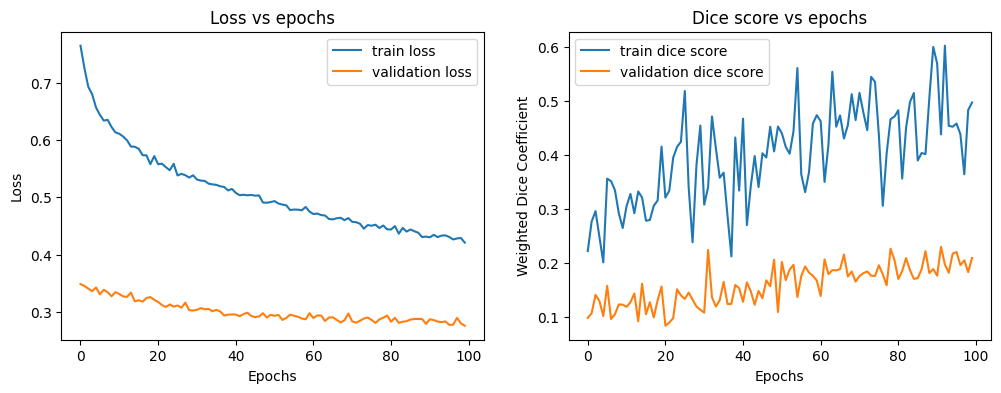

In [80]:
# recompile model
model = UNet(out_channels=8)

# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 32
EPOCHS = 100
NUM_WORKERS = 12

patch_cielab_20x_train_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="CIELAB",
    transform=train_transform,
    seed=0
)

patch_cielab_20x_val_dataset = PatchDataset(
    imgPaths=val_20x_img_path,
    maskPaths=val_20x_mask_path,
    mode="CIELAB",
    transform=val_transform,
    seed=0
)

if __name__ == "__main__":

    worker_g = torch.Generator()
    worker_g.manual_seed(0)
    train_batches = DataLoader(
        patch_cielab_20x_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_cielab_20x_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )

    # define the loss function and the optimizer
    criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    # train the network
    history = run_train_loop(model, 8, train_batches, valid_batches, len(patch_rgb_20x_train_dataset), len(patch_rgb_20x_val_dataset), EPOCHS, criterion, optimizer, "unetset-cielab-20x")
    torch.save(
        {
            "epoch": 100,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
        },
        f"unetset1_model_final.pth"
    )

    # display the total time needed to perform the training
    end_time = time.time()
    print(f"Total time taken to train the model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history)

<i>Optional garbage collection to free up space</i>

In [81]:
torch.cuda.empty_cache()
gc.collect()

7150

#### Sample training 3
black and white 20x, learning rate: 1e-4, batch size: 32, 100 epochs

100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 1/100 Train Loss: 0.7714 Validation Loss: 0.3587, Train Dice Score: 0.1431 Validation Dice Score: 0.1033


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 2/100 Train Loss: 0.7409 Validation Loss: 0.3458, Train Dice Score: 0.1772 Validation Dice Score: 0.1032


100%|██████████| 377/377 [01:26<00:00,  4.33it/s]


Epoch 3/100 Train Loss: 0.7181 Validation Loss: 0.3555, Train Dice Score: 0.2434 Validation Dice Score: 0.0926


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 4/100 Train Loss: 0.7137 Validation Loss: 0.3429, Train Dice Score: 0.1774 Validation Dice Score: 0.0911


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 5/100 Train Loss: 0.6962 Validation Loss: 0.3414, Train Dice Score: 0.2267 Validation Dice Score: 0.0859


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 6/100 Train Loss: 0.6886 Validation Loss: 0.3395, Train Dice Score: 0.2142 Validation Dice Score: 0.0925


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 7/100 Train Loss: 0.6800 Validation Loss: 0.3367, Train Dice Score: 0.1459 Validation Dice Score: 0.0895


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 8/100 Train Loss: 0.6707 Validation Loss: 0.3355, Train Dice Score: 0.2766 Validation Dice Score: 0.1136


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 9/100 Train Loss: 0.6684 Validation Loss: 0.3330, Train Dice Score: 0.3056 Validation Dice Score: 0.1090


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 10/100 Train Loss: 0.6666 Validation Loss: 0.3274, Train Dice Score: 0.2232 Validation Dice Score: 0.1079


100%|██████████| 377/377 [01:26<00:00,  4.33it/s]


Epoch 11/100 Train Loss: 0.6598 Validation Loss: 0.3269, Train Dice Score: 0.1898 Validation Dice Score: 0.0778


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 12/100 Train Loss: 0.6452 Validation Loss: 0.3236, Train Dice Score: 0.2085 Validation Dice Score: 0.1099


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 13/100 Train Loss: 0.6434 Validation Loss: 0.3295, Train Dice Score: 0.1800 Validation Dice Score: 0.1315


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 14/100 Train Loss: 0.6421 Validation Loss: 0.3239, Train Dice Score: 0.2175 Validation Dice Score: 0.1317


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 15/100 Train Loss: 0.6324 Validation Loss: 0.3253, Train Dice Score: 0.2557 Validation Dice Score: 0.1155


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 16/100 Train Loss: 0.6327 Validation Loss: 0.3249, Train Dice Score: 0.3200 Validation Dice Score: 0.0992


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 17/100 Train Loss: 0.6197 Validation Loss: 0.3251, Train Dice Score: 0.3504 Validation Dice Score: 0.1240


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 18/100 Train Loss: 0.6226 Validation Loss: 0.3203, Train Dice Score: 0.2582 Validation Dice Score: 0.1116


100%|██████████| 377/377 [01:26<00:00,  4.33it/s]


Epoch 19/100 Train Loss: 0.6164 Validation Loss: 0.3230, Train Dice Score: 0.3250 Validation Dice Score: 0.1110


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 20/100 Train Loss: 0.6110 Validation Loss: 0.3216, Train Dice Score: 0.3748 Validation Dice Score: 0.1236


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 21/100 Train Loss: 0.5997 Validation Loss: 0.3191, Train Dice Score: 0.2900 Validation Dice Score: 0.1270


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 22/100 Train Loss: 0.5965 Validation Loss: 0.3203, Train Dice Score: 0.3262 Validation Dice Score: 0.1181


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 23/100 Train Loss: 0.5993 Validation Loss: 0.3194, Train Dice Score: 0.2727 Validation Dice Score: 0.1339


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 24/100 Train Loss: 0.5939 Validation Loss: 0.3168, Train Dice Score: 0.3553 Validation Dice Score: 0.1066


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 25/100 Train Loss: 0.5937 Validation Loss: 0.3122, Train Dice Score: 0.4028 Validation Dice Score: 0.1096


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 26/100 Train Loss: 0.5888 Validation Loss: 0.3140, Train Dice Score: 0.4131 Validation Dice Score: 0.1468


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 27/100 Train Loss: 0.5818 Validation Loss: 0.3110, Train Dice Score: 0.3645 Validation Dice Score: 0.1303


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 28/100 Train Loss: 0.5742 Validation Loss: 0.3131, Train Dice Score: 0.3532 Validation Dice Score: 0.1390


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 29/100 Train Loss: 0.5663 Validation Loss: 0.3075, Train Dice Score: 0.3515 Validation Dice Score: 0.1103


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 30/100 Train Loss: 0.5714 Validation Loss: 0.3090, Train Dice Score: 0.3568 Validation Dice Score: 0.1058


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 31/100 Train Loss: 0.5620 Validation Loss: 0.3119, Train Dice Score: 0.4797 Validation Dice Score: 0.1285


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 32/100 Train Loss: 0.5665 Validation Loss: 0.3143, Train Dice Score: 0.3816 Validation Dice Score: 0.1230


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 33/100 Train Loss: 0.5696 Validation Loss: 0.3118, Train Dice Score: 0.3765 Validation Dice Score: 0.1193


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 34/100 Train Loss: 0.5589 Validation Loss: 0.3034, Train Dice Score: 0.3485 Validation Dice Score: 0.1115


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 35/100 Train Loss: 0.5528 Validation Loss: 0.3024, Train Dice Score: 0.2816 Validation Dice Score: 0.1274


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 36/100 Train Loss: 0.5508 Validation Loss: 0.3019, Train Dice Score: 0.3850 Validation Dice Score: 0.1368


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 37/100 Train Loss: 0.5488 Validation Loss: 0.3091, Train Dice Score: 0.3432 Validation Dice Score: 0.1594


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 38/100 Train Loss: 0.5504 Validation Loss: 0.3032, Train Dice Score: 0.1854 Validation Dice Score: 0.1287


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 39/100 Train Loss: 0.5463 Validation Loss: 0.2973, Train Dice Score: 0.2852 Validation Dice Score: 0.1236


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 40/100 Train Loss: 0.5402 Validation Loss: 0.3036, Train Dice Score: 0.4689 Validation Dice Score: 0.1428


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 41/100 Train Loss: 0.5422 Validation Loss: 0.2992, Train Dice Score: 0.3148 Validation Dice Score: 0.1708


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 42/100 Train Loss: 0.5435 Validation Loss: 0.3025, Train Dice Score: 0.3585 Validation Dice Score: 0.1753


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 43/100 Train Loss: 0.5362 Validation Loss: 0.3064, Train Dice Score: 0.2342 Validation Dice Score: 0.1531


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 44/100 Train Loss: 0.5309 Validation Loss: 0.3078, Train Dice Score: 0.3845 Validation Dice Score: 0.1218


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 45/100 Train Loss: 0.5295 Validation Loss: 0.3010, Train Dice Score: 0.3803 Validation Dice Score: 0.1662


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 46/100 Train Loss: 0.5263 Validation Loss: 0.2989, Train Dice Score: 0.3009 Validation Dice Score: 0.1360


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 47/100 Train Loss: 0.5277 Validation Loss: 0.2956, Train Dice Score: 0.3747 Validation Dice Score: 0.1460


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 48/100 Train Loss: 0.5276 Validation Loss: 0.2917, Train Dice Score: 0.3192 Validation Dice Score: 0.1692


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 49/100 Train Loss: 0.5223 Validation Loss: 0.3031, Train Dice Score: 0.3145 Validation Dice Score: 0.1522


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 50/100 Train Loss: 0.5173 Validation Loss: 0.2929, Train Dice Score: 0.4133 Validation Dice Score: 0.1832


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 51/100 Train Loss: 0.5165 Validation Loss: 0.2913, Train Dice Score: 0.3628 Validation Dice Score: 0.1630


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 52/100 Train Loss: 0.5171 Validation Loss: 0.2906, Train Dice Score: 0.4248 Validation Dice Score: 0.1661


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 53/100 Train Loss: 0.5165 Validation Loss: 0.2954, Train Dice Score: 0.2461 Validation Dice Score: 0.1604


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 54/100 Train Loss: 0.5156 Validation Loss: 0.2951, Train Dice Score: 0.3613 Validation Dice Score: 0.2223


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 55/100 Train Loss: 0.5093 Validation Loss: 0.2849, Train Dice Score: 0.3782 Validation Dice Score: 0.1884


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 56/100 Train Loss: 0.5130 Validation Loss: 0.2933, Train Dice Score: 0.3711 Validation Dice Score: 0.1805


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 57/100 Train Loss: 0.5040 Validation Loss: 0.2872, Train Dice Score: 0.4354 Validation Dice Score: 0.1587


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 58/100 Train Loss: 0.5053 Validation Loss: 0.2847, Train Dice Score: 0.3368 Validation Dice Score: 0.1951


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 59/100 Train Loss: 0.5006 Validation Loss: 0.2917, Train Dice Score: 0.3343 Validation Dice Score: 0.1802


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 60/100 Train Loss: 0.5065 Validation Loss: 0.2906, Train Dice Score: 0.4140 Validation Dice Score: 0.2074


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 61/100 Train Loss: 0.4992 Validation Loss: 0.2919, Train Dice Score: 0.4454 Validation Dice Score: 0.2005


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 62/100 Train Loss: 0.4996 Validation Loss: 0.2878, Train Dice Score: 0.2796 Validation Dice Score: 0.1887


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 63/100 Train Loss: 0.5018 Validation Loss: 0.2826, Train Dice Score: 0.4608 Validation Dice Score: 0.1599


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 64/100 Train Loss: 0.4899 Validation Loss: 0.2843, Train Dice Score: 0.5038 Validation Dice Score: 0.1899


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 65/100 Train Loss: 0.4965 Validation Loss: 0.2873, Train Dice Score: 0.4110 Validation Dice Score: 0.1732


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 66/100 Train Loss: 0.4947 Validation Loss: 0.2850, Train Dice Score: 0.3941 Validation Dice Score: 0.2117


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 67/100 Train Loss: 0.4956 Validation Loss: 0.2906, Train Dice Score: 0.3206 Validation Dice Score: 0.1646


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 68/100 Train Loss: 0.4906 Validation Loss: 0.2860, Train Dice Score: 0.4814 Validation Dice Score: 0.2008


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 69/100 Train Loss: 0.4912 Validation Loss: 0.2792, Train Dice Score: 0.3680 Validation Dice Score: 0.1639


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 70/100 Train Loss: 0.4859 Validation Loss: 0.2800, Train Dice Score: 0.4257 Validation Dice Score: 0.1860


100%|██████████| 377/377 [01:26<00:00,  4.34it/s]


Epoch 71/100 Train Loss: 0.4841 Validation Loss: 0.2805, Train Dice Score: 0.4452 Validation Dice Score: 0.1950


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 72/100 Train Loss: 0.4807 Validation Loss: 0.2836, Train Dice Score: 0.3857 Validation Dice Score: 0.1981


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 73/100 Train Loss: 0.4817 Validation Loss: 0.2826, Train Dice Score: 0.5499 Validation Dice Score: 0.1810


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 74/100 Train Loss: 0.4813 Validation Loss: 0.2811, Train Dice Score: 0.5947 Validation Dice Score: 0.1935


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 75/100 Train Loss: 0.4794 Validation Loss: 0.2807, Train Dice Score: 0.3928 Validation Dice Score: 0.1733


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 76/100 Train Loss: 0.4806 Validation Loss: 0.2807, Train Dice Score: 0.5691 Validation Dice Score: 0.2068


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 77/100 Train Loss: 0.4738 Validation Loss: 0.2742, Train Dice Score: 0.4825 Validation Dice Score: 0.1658


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 78/100 Train Loss: 0.4768 Validation Loss: 0.2806, Train Dice Score: 0.5029 Validation Dice Score: 0.1784


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 79/100 Train Loss: 0.4743 Validation Loss: 0.2821, Train Dice Score: 0.3542 Validation Dice Score: 0.1618


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 80/100 Train Loss: 0.4711 Validation Loss: 0.2808, Train Dice Score: 0.3942 Validation Dice Score: 0.1819


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 81/100 Train Loss: 0.4800 Validation Loss: 0.2818, Train Dice Score: 0.3844 Validation Dice Score: 0.1713


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 82/100 Train Loss: 0.4690 Validation Loss: 0.2805, Train Dice Score: 0.3936 Validation Dice Score: 0.1563


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 83/100 Train Loss: 0.4640 Validation Loss: 0.2759, Train Dice Score: 0.4307 Validation Dice Score: 0.1673


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 84/100 Train Loss: 0.4713 Validation Loss: 0.2757, Train Dice Score: 0.4130 Validation Dice Score: 0.1880


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 85/100 Train Loss: 0.4677 Validation Loss: 0.2774, Train Dice Score: 0.2898 Validation Dice Score: 0.1858


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 86/100 Train Loss: 0.4643 Validation Loss: 0.2808, Train Dice Score: 0.3838 Validation Dice Score: 0.2022


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 87/100 Train Loss: 0.4641 Validation Loss: 0.2842, Train Dice Score: 0.3920 Validation Dice Score: 0.1759


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 88/100 Train Loss: 0.4675 Validation Loss: 0.2744, Train Dice Score: 0.4758 Validation Dice Score: 0.1979


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 89/100 Train Loss: 0.4623 Validation Loss: 0.2740, Train Dice Score: 0.4715 Validation Dice Score: 0.1872


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 90/100 Train Loss: 0.4654 Validation Loss: 0.2821, Train Dice Score: 0.3388 Validation Dice Score: 0.1777


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 91/100 Train Loss: 0.4556 Validation Loss: 0.2738, Train Dice Score: 0.4969 Validation Dice Score: 0.1865


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 92/100 Train Loss: 0.4571 Validation Loss: 0.2773, Train Dice Score: 0.3846 Validation Dice Score: 0.2003


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 93/100 Train Loss: 0.4531 Validation Loss: 0.2771, Train Dice Score: 0.4439 Validation Dice Score: 0.1626


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 94/100 Train Loss: 0.4565 Validation Loss: 0.2781, Train Dice Score: 0.6273 Validation Dice Score: 0.1920


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 95/100 Train Loss: 0.4609 Validation Loss: 0.2761, Train Dice Score: 0.4878 Validation Dice Score: 0.1814


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 96/100 Train Loss: 0.4517 Validation Loss: 0.2716, Train Dice Score: 0.5009 Validation Dice Score: 0.1920


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 97/100 Train Loss: 0.4570 Validation Loss: 0.2755, Train Dice Score: 0.4625 Validation Dice Score: 0.2070


100%|██████████| 377/377 [01:27<00:00,  4.32it/s]


Epoch 98/100 Train Loss: 0.4533 Validation Loss: 0.2755, Train Dice Score: 0.5397 Validation Dice Score: 0.1869


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 99/100 Train Loss: 0.4522 Validation Loss: 0.2812, Train Dice Score: 0.4397 Validation Dice Score: 0.1632


100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


Epoch 100/100 Train Loss: 0.4509 Validation Loss: 0.2709, Train Dice Score: 0.4142 Validation Dice Score: 0.1985
Total time taken to train the model: 9175.90s


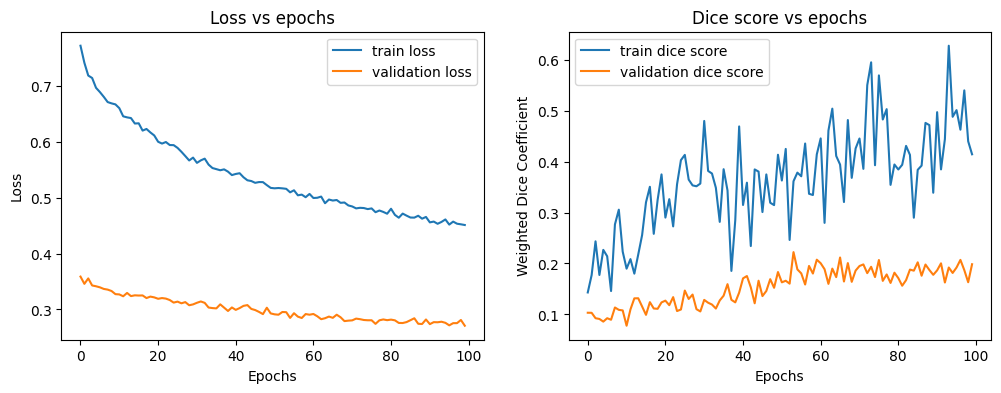

In [82]:
# recompile model
model = UNet(in_channels=1, out_channels=8)

# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 32
EPOCHS = 100
NUM_WORKERS = 12

patch_bw_20x_train_dataset = PatchDataset(
    imgPaths=train_20x_img_path,
    maskPaths=train_20x_mask_path,
    mode="BW",
    transform=train_transform,
    seed=0
)

patch_bw_20x_val_dataset = PatchDataset(
    imgPaths=val_20x_img_path,
    maskPaths=val_20x_mask_path,
    mode="BW",
    transform=val_transform,
    seed=0
)

if __name__ == "__main__":

    worker_g = torch.Generator()
    worker_g.manual_seed(0)
    train_batches = DataLoader(
        patch_bw_20x_train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        patch_bw_20x_val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=True, prefetch_factor=16
    )

    # define the loss function and the optimizer
    criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    start_time = time.time()

    # train the network
    history = run_train_loop(model, 8, train_batches, valid_batches, len(patch_rgb_20x_train_dataset), len(patch_rgb_20x_val_dataset), EPOCHS, criterion, optimizer, "unetset-bw-20x")
    torch.save(
        {
            "epoch": 100,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
        },
        f"unetset1_model_final.pth"
    )

    # display the total time needed to perform the training
    end_time = time.time()
    print(f"Total time taken to train the model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history)

<i>Optional garbage collection to free up space</i>

In [83]:
torch.cuda.empty_cache()
gc.collect()

7190